In [1]:
machine = 'mac'
machine = 'magny'

In [2]:
if machine == 'magny':
    filedir = "/home/extmilan/masterthesis/files/"
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
    plotdir = "/home/extmilan/masterthesis/plots/"
elif machine == 'mac':
    filedir = "/Users/smilanov/Documents/masterthesis/auriga_files/files/"
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
else:
    raise NotADirectoryError

In [3]:
from galpy.potential import MiyamotoNagaiPotential, NFWPotential, HernquistPotential
from galpy.actionAngle import estimateDeltaStaeckel, actionAngleStaeckel

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind

from auriga_basics import *
from auriga_functions import *

import numpy as np
from IPython.display import Image, display

import corner

import datetime
import random

import copy

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Circle
from matplotlib import animation

import datetime

cmap = copy.copy(plt.cm.inferno)
cmap.set_bad((0,0,0))

%matplotlib inline

In [4]:
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*
level = 4
if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"

    for snapnr in range(127,128,1):
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[4], 
            haloid=0, galradfac=0.1, verbose=True) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
        

level   : 4
halo    : 24
snapnr  : 127
basedir : /hits/universe/GigaGalaxy/level4_MHD/
halodir : /hits/universe/GigaGalaxy/level4_MHD/halo_24/
snappath: /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/

[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]



In [5]:
#_____reference values for galpy_____
_REFR0_kpc = 8.

#_____function that sets-up galpy potential_____
def setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB):
    
    #test input:
    if (a_MND_kpc <= 0.) or (b_MND_kpc <= 0.) or (a_NFWH_kpc <= 0.) or (a_HB_kpc <= 0.) \
       or (n_MND <= 0.) or (n_NFWH <= 0.) or (n_HB <= 0.) or (n_MND >= 1.) or (n_NFWH >= 1.) or (n_HB >= 1.):
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The input parameters for the scaling profiles do not correspond to a physical potential.')
    if np.fabs(n_MND + n_NFWH + n_HB - 1.) > 1e-7:
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The sum of the normalization does not add up to 1.')
        
    #trafo to galpy units:
    a_MND  = a_MND_kpc / _REFR0_kpc
    b_MND  = b_MND_kpc / _REFR0_kpc
    a_NFWH = a_NFWH_kpc / _REFR0_kpc
    a_HB   = a_HB_kpc / _REFR0_kpc
    
    #setup potential:
    disk = MiyamotoNagaiPotential(
                a = a_MND,
                b = b_MND,
                normalize = n_MND)
    halo = NFWPotential(
                a = a_NFWH,
                normalize = n_NFWH)
    bulge = HernquistPotential(
                a = a_HB,
                normalize = n_HB)
    return [disk, halo, bulge]


Action evolution parameters
---

- IDlist (somehow.... find where dwarf (67 für den Anfangs) merges)
- startnr
- fit routine = emcxee 1 (in v0.1; more maybe in v0.2)
- delta fix or calculation
- figure (with labels, range, title etc predefined)
- in v0.2 possibility for wrong potential


Get IDs of merged stars from snapshot 72 to 73
---
Maybe instead take table made in 2dwarf

In [6]:
level = 4
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(73,74,1):
        print("snapnr  : {0}".format(snapnr))
        print(datetime.datetime.now().time())
        #print("snappath: {0}\n".format(snappath))
        s1, sf1 = eat_snap_and_fof(level, halo_number, snapnr-1, snappath, loadonlytype=[4], 
            haloid=0, galradfac=0.1, verbose=False) 
        
        s2, sf2 = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[4], 
            haloid=0, galradfac=0.1, verbose=False) 
        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s1.data['gmet'] = np.maximum( s1.data['gmet'], 1e-40 )
        s2.data['gmet'] = np.maximum( s2.data['gmet'], 1e-40 )
        
        # get positions and velocities of all stars 
        istars1, = np.where( (s1.type == 4) & (s1.halo == 0) )#& (s.subhalo == 0))
        (x1_kpc, y1_kpc, z1_kpc), (vx1_kms, vy1_kms, vz1_kms), rxyz1_kpc, rxy1_kpc = get_cartesian_vectors(s1, sf1, istars1)
        istars2, = np.where( (s2.type == 4) & (s2.halo == 0) )#& (s.subhalo == 0))
        (x2_kpc, y2_kpc, z2_kpc), (vx2_kms, vy2_kms, vz2_kms), rxyz2_kpc, rxy2_kpc = get_cartesian_vectors(s2, sf2, istars2)
 
        # mask for stars in first snapshot in first subhalo
        istarssub1, = np.where( (s1.type == 4) & (s1.halo == 0) & (s1.subhalo == 1) )
        # get their IDs
        ids_halo1 = s1.id[istarssub1]
        # check which of these stars are in the main galaxy in the snapshot after
        idsmergermask = np.isin(s2.id[np.where(s2.subhalo ==0)], ids_halo1)
        # get their IDs
        ids_merger = s2.id[np.where(s2.subhalo ==0)][idsmergermask]        

snapnr  : 73
11:36:56.615954
[ 15.1824646   14.63997269  15.67546272]
Found 536367 stars.
Rotated pos.
Rotated vel.
[ 15.47813797  14.92653275  15.98590374]
Found 667800 stars.
Rotated pos.
Rotated vel.


In [7]:
ids_merger = np.loadtxt(filedir + 'surviving_ids_snapshot_72_sh_1.txt')

In [ ]:
part_num = 500
rand_samp = np.array(random.sample(list(enumerate(ids_merger)), part_num))
rand_ind = rand_samp[:,0].astype(int)
IDS = rand_samp[:, 1]

IDS = ids_merger


[  7.80217285e+04   1.64043359e+06   1.57911358e+08   6.12705943e+08
   2.28509534e+01   2.32099235e+01   2.48745077e+01   2.21387058e+01
   2.49604197e+01   2.66769796e+01   2.55140637e+01   2.59304645e+01
   2.70842332e+01   2.84570225e+01   1.62914631e+01   1.72237174e+01
   1.71550164e+01   1.95837322e+01   1.58366083e+01   2.15904926e+01
   2.04420458e+01   2.03348422e+01   2.24132616e+01   2.22738610e+01
   2.26541723e+01   2.54783549e+01   2.34908904e+01   2.81025533e+01
   3.10061675e+01   2.38856763e+01   2.83977568e+01   2.15450792e+01
   3.93942245e+01   3.70846724e+01   3.73507691e+01   3.71482726e+01
   3.92497288e+01   3.57442843e+01   3.27585204e+01   3.93970959e+01
   3.92198383e+01   4.04246157e+01   5.17129026e+01   4.24758500e+01
   4.37829489e+01   5.33670938e+01   5.38384718e+01   5.23320645e+01
   5.27735197e+01   5.12780950e+01   6.81427468e+01   6.89837539e+01
   6.54052404e+01   7.18725441e+01   7.47283274e+01   7.48131255e+01
   8.02414243e+01   8.24889694e+01

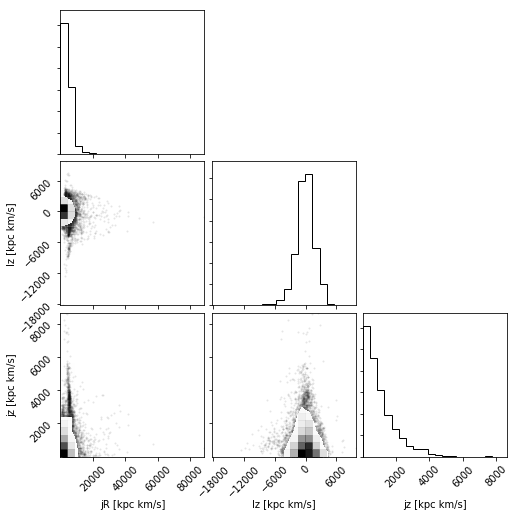

first ii
181.482150949
125
91
snapnr: 94
11:45:12.775659
[ 22.47373009  21.69274902  23.72468185]
Found 1349298 stars.
Rotated pos.
Rotated vel.
9728
[[  2.04926489e+02   5.29149696e+02   1.34165646e+02 ...,   3.43754507e+03
    4.21611839e+03   1.85204547e+03]
 [  2.71448176e+02   1.44355083e+02  -5.62616501e+02 ...,  -1.21895534e+04
   -1.14840830e+04  -1.83677017e+04]
 [  2.72121739e+02   4.68319046e+01   6.04789229e+02 ...,   4.90752433e+02
    5.59149035e+02   3.04204335e+00]]


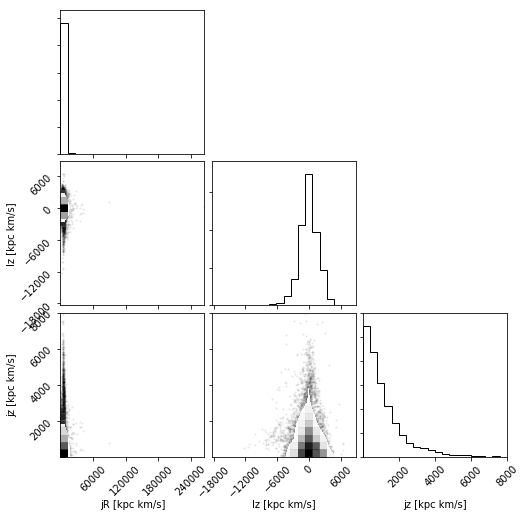

first ii
180.611587613
125
92
snapnr: 95
11:53:10.207346
[ 22.7996521   22.0025444   24.08984756]
Found 1373081 stars.
Rotated pos.
Rotated vel.
9728
[[  1.80040374e+02   4.68961151e+02   9.17413427e+02 ...,   1.63364226e+04
    3.35689348e+03   1.46476295e+03]
 [  2.52689593e+02   1.33092405e+02   6.01726073e+02 ...,  -7.06181462e+02
   -1.36154559e+04  -2.02964380e+04]
 [  3.19577282e+02   1.14791517e+02   8.03138567e+01 ...,   8.22336868e+02
    6.59794459e+02   6.72729402e+00]]


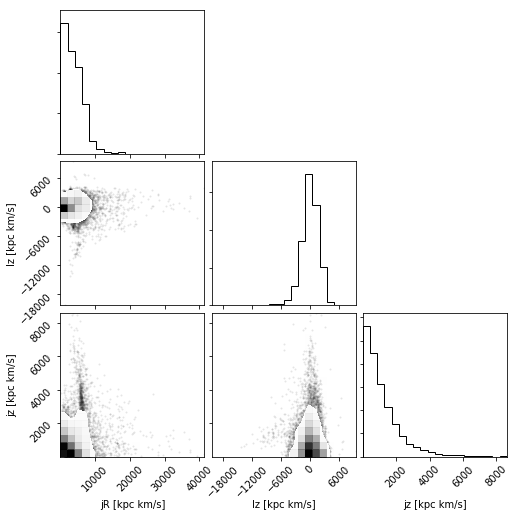

first ii
181.360607548
125
93
snapnr: 96
12:01:09.393204
[ 23.13161278  22.31706619  24.45867538]
Found 1400280 stars.
Rotated pos.
Rotated vel.
9728
[[  1.38095504e+02   5.60328261e+02   6.81832425e+02 ...,   1.20893699e+04
    1.80693175e+04   8.35805469e+02]
 [  2.47853553e+02   1.37714264e+02   4.11456767e+02 ...,  -4.49380189e+03
   -4.86866655e+03  -2.17485022e+04]
 [  3.72770823e+02   1.72060414e+02   3.98732581e+02 ...,   1.58940539e+03
    8.30864672e+02   7.52581795e+00]]


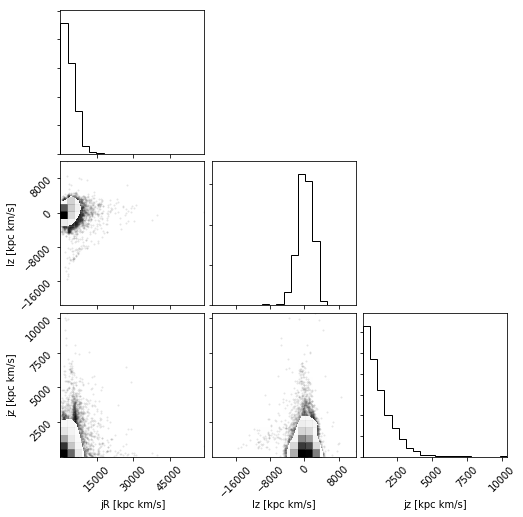

first ii
183.006397259
125
94
snapnr: 97
12:09:07.555246
[ 23.46821594  22.63773918  24.8325634 ]
Found 1416479 stars.
Rotated pos.
Rotated vel.
9728
[[   129.61614548   1507.59759568   1280.47208237 ...,   9238.2159136
    8923.70198728   1010.60723132]
 [   256.08078243     85.84128681   -143.68996919 ...,  -8347.63885377
   -8367.58117839 -20811.262927  ]
 [   395.38863733    269.96384182     90.33822977 ...,   1275.26374978
    1263.95290498    190.47598089]]


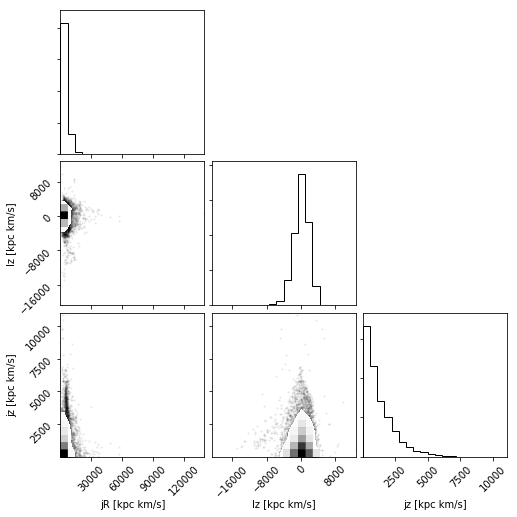

first ii
182.657434601
125
95
snapnr: 98
12:17:05.595393
[ 23.80860329  22.96368408  25.21352386]
Found 1428816 stars.
Rotated pos.
Rotated vel.
9728
[[   452.93026112     93.73545336    448.71375292 ...,   8355.01620396
    1856.43486051   8655.27813001]
 [   133.70692843    220.364098      276.72087203 ...,  -7694.30995348
  -18482.58924037  -9239.0962704 ]
 [   260.90343782    475.35301678    561.41363301 ...,   4495.77449233
     299.26031972   4401.95319549]]


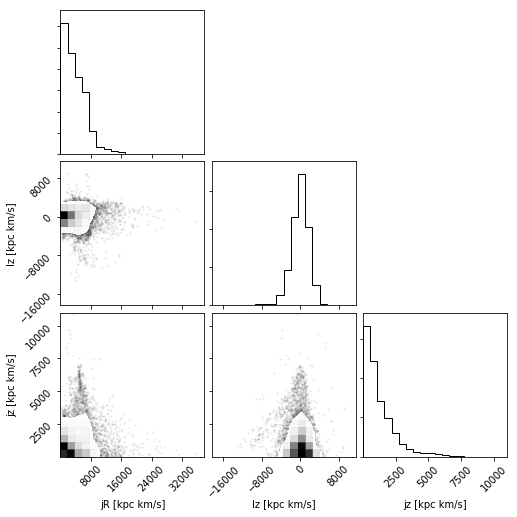

first ii
184.238608904
125
96
snapnr: 99
12:25:03.929825
[ 24.15342522  23.29395103  25.60112953]
Found 1445387 stars.
Rotated pos.
Rotated vel.
9728
[[   423.07622149     79.58881898   1405.77218797 ...,   6485.70012824
    2395.88389522   5572.06971601]
 [   151.63003588    196.6886606     314.21506127 ...,  -9536.43536988
  -17518.52334137 -10454.39687325]
 [   241.15059388    520.93252944    163.10408125 ...,   1156.78202164
     407.61327478   4632.93010119]]


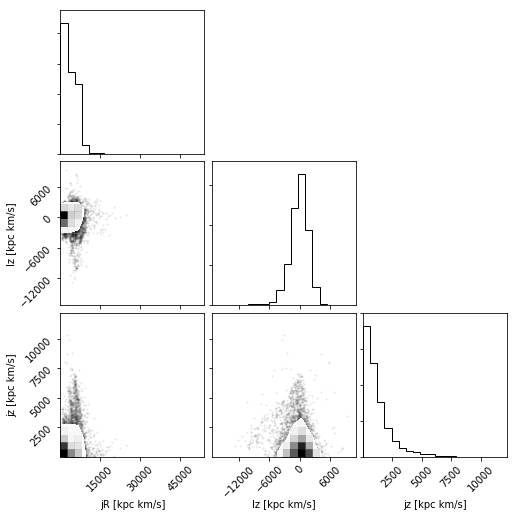

first ii
185.416368871
125
97
snapnr: 100
12:33:02.404536
[ 24.50271797  23.62892342  25.99520683]
Found 1470007 stars.
Rotated pos.
Rotated vel.
9728
[[    75.7475143     212.29858418    556.29076733 ...,   8225.7525939
    5307.16770301   1771.89250204]
 [   181.29295731    103.58514708     97.48630232 ..., -10369.75681215
  -13257.70044168  -7484.52876169]
 [   751.31042952    796.6432741     236.08737466 ...,    972.10763767
    2758.77515468   3432.33297839]]


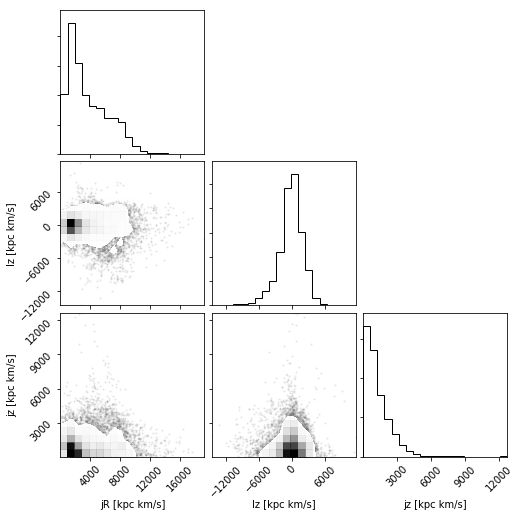

first ii
191.281364058
125
103
snapnr: 106
13:21:47.746174
[ 26.58517647  25.61821175  28.35095024]
Found 1553881 stars.
Rotated pos.
Rotated vel.
9728
[[    30.14840518    285.88343873    921.37134239 ...,   8524.12752584
    8557.20700493   5045.03298321]
 [   183.94120011     87.87452719     85.07467471 ...,  -9509.77851461
   -9854.7948031  -14307.10525991]
 [   724.02111619    693.00361973    212.70319492 ...,   1734.45839784
    1241.28228829   2656.64098418]]


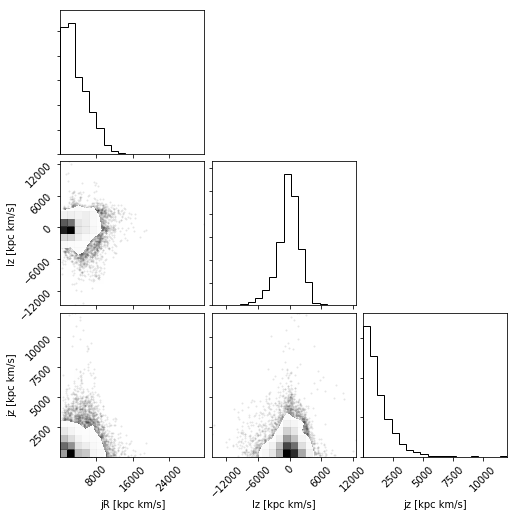

first ii
190.796318165
125
104
snapnr: 107
13:29:57.053925
[ 26.97145081  25.98770905  28.78736305]
Found 1562371 stars.
Rotated pos.
Rotated vel.
9728
[[   431.64023655     19.94286969    479.10719733 ...,   8120.25131116
    8203.07598799   5224.04689871]
 [   155.96210355    163.36435269    131.63371975 ...,  -9920.48128892
  -10309.31292435 -13918.08425806]
 [   385.9187368     734.137988      356.70450726 ...,   2040.37677666
    1485.35300315   2656.87310714]]


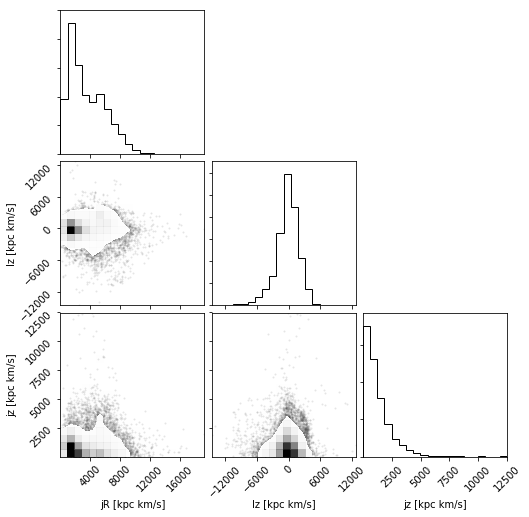

first ii
191.840997057
125
105
snapnr: 108
13:38:05.819887
[ 27.23214722  26.23708725  29.08192825]
Found 1625123 stars.
Rotated pos.
Rotated vel.
9728
[[   242.38291548    435.39459758    146.74905999 ...,   7687.53310957
    7798.89306449   5949.53849548]
 [   161.4852973     248.36952312    171.08374139 ..., -10776.58004549
  -11237.9508229  -13034.48719619]
 [   294.85387391    253.62748339    797.44052589 ...,   2041.47715138
    1455.71676369   2430.53708639]]


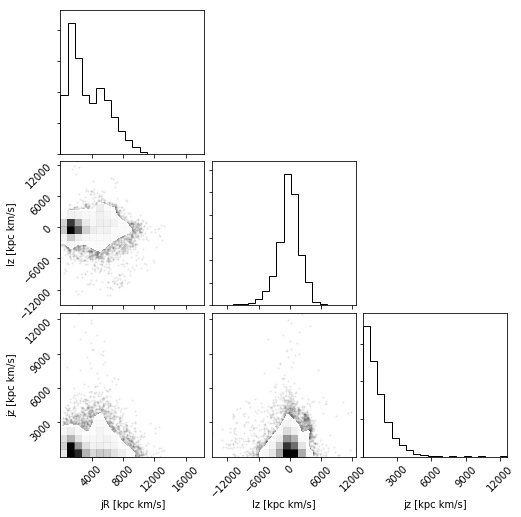

first ii
193.051245577
125
106
snapnr: 109
13:46:09.309932
[ 27.62681198  26.61546135  29.52968025]
Found 1597012 stars.
Rotated pos.
Rotated vel.
9728
[[   221.52731285    134.42429225    443.64420952 ...,   7623.18799504
    7651.96423394   5637.09533312]
 [   187.94175338    166.34949638    123.83787416 ...,  -8929.29394328
   -8333.97478643 -14267.78493602]
 [   347.33604251    733.7623249     413.22856505 ...,   2741.5306975
      61.46327874   1510.47691467]]


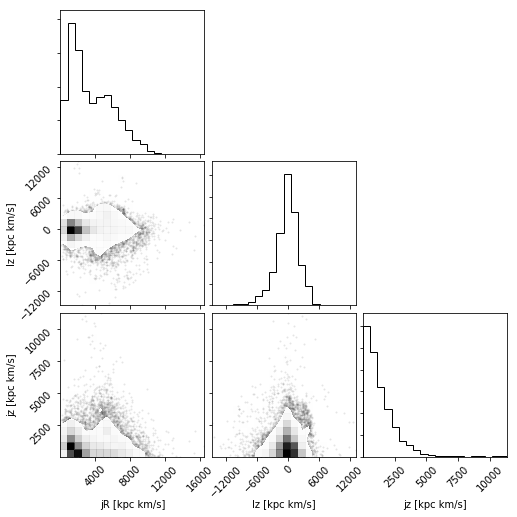

first ii
194.181374036
125
107
snapnr: 110
13:54:21.385659
[ 28.02821541  26.99830246  29.98339081]
Found 1596516 stars.
Rotated pos.
Rotated vel.
9728
[[   137.35532861    232.11612113   1385.75934805 ...,   3740.14641166
    5285.63173591   3863.97049233]
 [   135.04137792    143.81477459    128.86195962 ..., -15867.85026931
  -14626.22547918 -20237.03785214]
 [   629.26446214    735.8441019     217.09825345 ...,   2809.5450763
    1331.60411429   1249.88829715]]


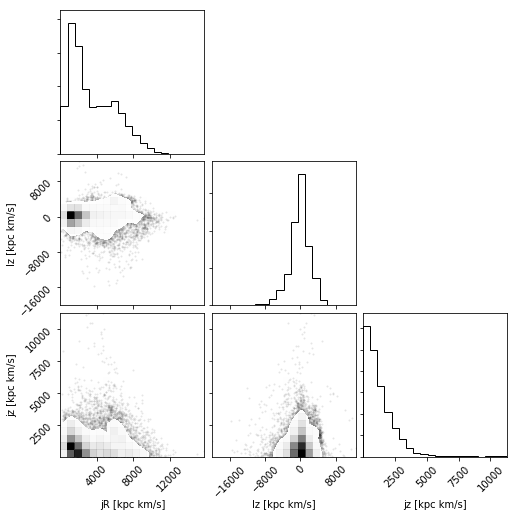

first ii
195.546797014
125
108
snapnr: 111
14:02:30.939624
[ 28.29884148  27.25717163  30.28975487]
Found 1611388 stars.
Rotated pos.
Rotated vel.
9728
[[   133.30773854    310.80942835    603.69453899 ...,   3626.390933
    3592.0881105    3990.02019689]
 [   112.62676807     90.9613081     108.80589789 ..., -15616.06596435
  -18754.57624225 -21060.80717468]
 [   629.13563178    821.0439637      67.37676742 ...,   5249.670112
    2501.38215733   1229.9298597 ]]


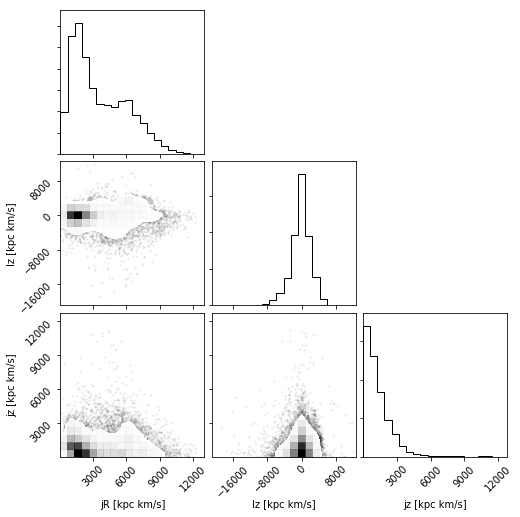

first ii
195.669159893
125
109
snapnr: 112
14:10:38.601709
[ 28.71037102  27.65019417  30.75450516]
Found 1681756 stars.
Rotated pos.
Rotated vel.
9728
[[   136.21737676    118.58338699    741.34523981 ...,   3385.51266805
    3805.16653501   3334.44471158]
 [    71.39459009    -52.99609446     76.57092733 ..., -19541.89753033
  -20979.34899511 -17123.79681826]
 [   670.24675255    876.0874027      73.60795498 ...,   1969.5523837
     866.71618711   4381.24765436]]


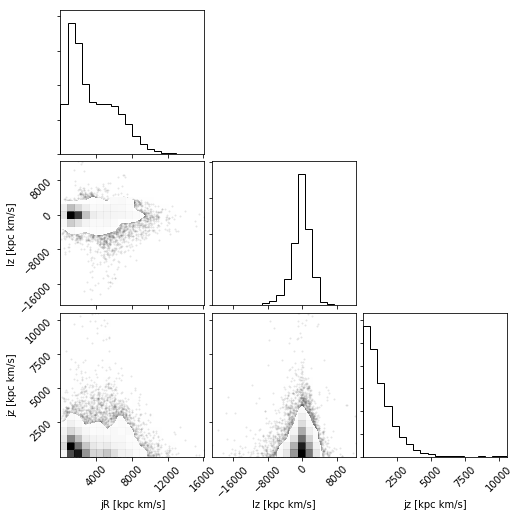

first ii
197.468486697
125
110
snapnr: 113
14:18:49.907276
[ 29.12677383  28.04948807  31.22624779]
Found 1636296 stars.
Rotated pos.
Rotated vel.
9728
[[  1.56296230e+02   6.93999355e+01   5.20157329e+02 ...,   3.29296534e+03
    3.00222249e+03   2.95118963e+03]
 [  7.44652233e+01  -2.11568790e+01  -8.34978999e+00 ...,  -2.12432263e+04
   -1.98685520e+04  -1.74246701e+04]
 [  6.74293121e+02   9.69676920e+02   5.76272506e+02 ...,   8.96912586e+02
    1.96732668e+03   4.21966826e+03]]
/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



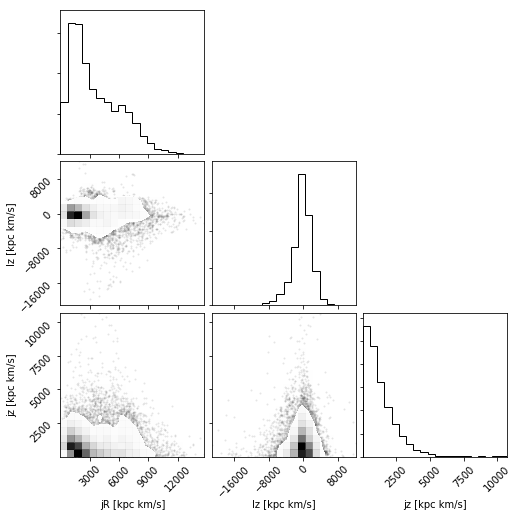

first ii
196.730708423
125
111
snapnr: 114
14:27:04.045768
[ 29.40730476  28.31895065  31.54471207]
Found 1680675 stars.
Rotated pos.
Rotated vel.
9728
[[   147.31976228     32.45633084    818.74012931 ...,   3207.77839247
    2939.0628831    2758.9015331 ]
 [    36.24725723    121.91946377    -68.28339173 ..., -21743.30462584
  -20724.97945772 -18558.80133005]
 [   683.17950702    917.30489845     76.06763078 ...,    694.22361725
    1517.43057052   3482.67137195]]


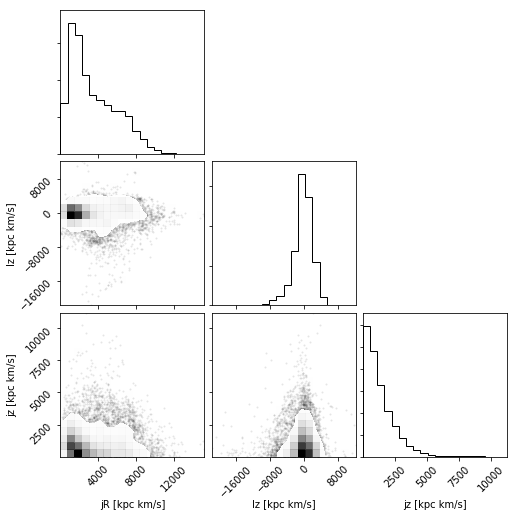

first ii
198.289966585
125
112
snapnr: 115
14:35:08.824840
[ 29.83269691  28.72842789  32.02832794]
Found 1689680 stars.
Rotated pos.
Rotated vel.
9728
[[   109.40288327    351.21975516    295.42537674 ...,   2564.2674383
    2480.94587614   2588.77655367]
 [    75.03801103    101.5803716      34.72230438 ..., -21752.99116974
  -20887.87040527 -18792.47349747]
 [   660.31838388    942.12504134    543.1790758  ...,    653.36354524
    1454.40664698   3507.98319624]]


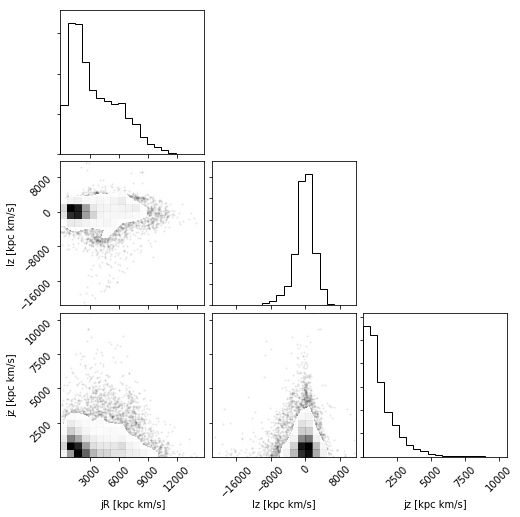

first ii
196.1843304
125
113
snapnr: 116
14:43:19.805436
[ 30.11922264  29.0051918   32.35468674]
Found 1690508 stars.
Rotated pos.
Rotated vel.
9728
[[  1.42563911e+02   2.04102918e+02   4.58784514e+02 ...,   2.05567532e+03
    2.26566162e+03   2.75883508e+03]
 [  6.18340971e+01   8.09317182e+01   9.25347955e+00 ...,  -2.15350814e+04
   -2.05370817e+04  -1.83604702e+04]
 [  6.62847048e+02   7.52280000e+02   4.72430589e+02 ...,   6.98053406e+02
    1.59828964e+03   3.83103284e+03]]


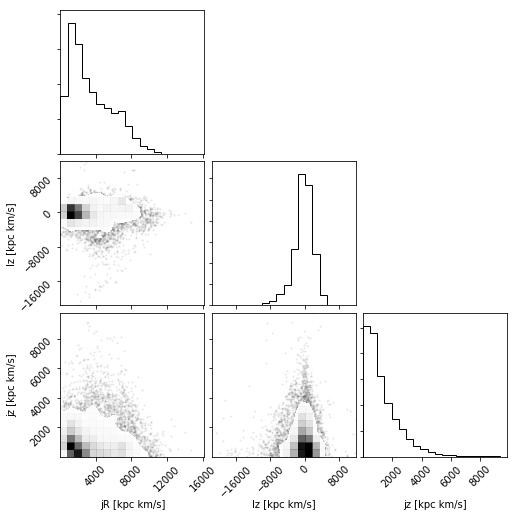

first ii
199.677123329
125
114
snapnr: 117
14:51:26.718580
[ 30.55345726  29.42549706  32.85093689]
Found 1709507 stars.
Rotated pos.
Rotated vel.
9728
[[  2.27696552e+02   8.00845459e+01   2.39746633e+02 ...,   1.38378632e+03
    2.39043282e+03   3.31846846e+03]
 [ -1.99177047e+01   1.10507338e+02   6.84177053e+01 ...,  -2.08820054e+04
   -1.98775993e+04  -1.77193871e+04]
 [  6.51916868e+02   7.91728195e+02   4.43884281e+02 ...,   6.79632927e+02
    1.74890914e+03   4.14474769e+03]]


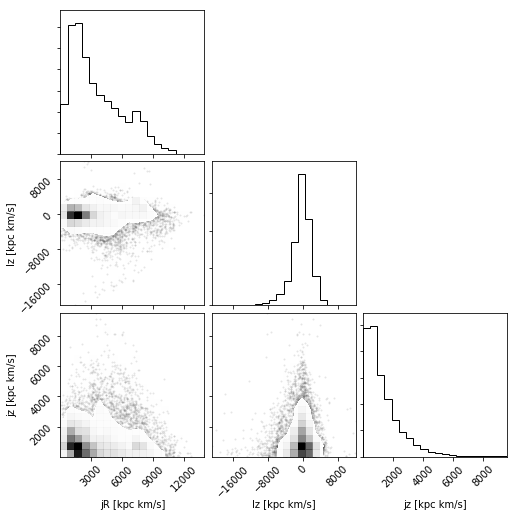

first ii
204.949994903
125
115
snapnr: 118
14:59:34.264531
[ 30.99422073  29.85132217  33.35467911]
Found 1704816 stars.
Rotated pos.
Rotated vel.
9728
[[  2.00280426e+02   3.13897935e+02   1.23399562e+02 ...,   1.56313055e+03
    2.86681306e+03   3.88522098e+03]
 [  6.26100858e+01   1.41578454e+01   9.95911975e+00 ...,  -2.09663585e+04
   -2.02151713e+04  -1.80042328e+04]
 [  5.67488480e+02   6.44568691e+02   9.20724091e+02 ...,   6.79983233e+02
    1.77719493e+03   4.20475083e+03]]


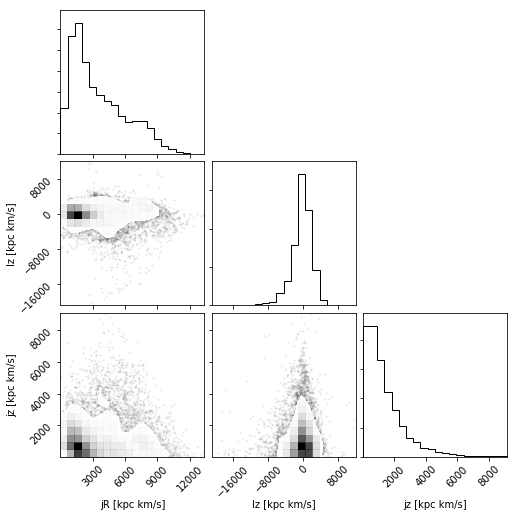

first ii
203.719636265
125
116
snapnr: 119
15:07:39.563419
[ 31.29102707  30.13891983  33.69516754]
Found 1717424 stars.
Rotated pos.
Rotated vel.
9728
[[    96.98176442    562.69440265    109.07306592 ...,   1977.78195914
    3556.37658214   4716.47088218]
 [   -36.60756907     25.10059803    -52.12776195 ..., -20454.02220435
  -19476.45175769 -17093.65847334]
 [   997.46125107    289.74217764   1194.25225135 ...,    699.47210321
    1836.12234102   4362.37180305]]


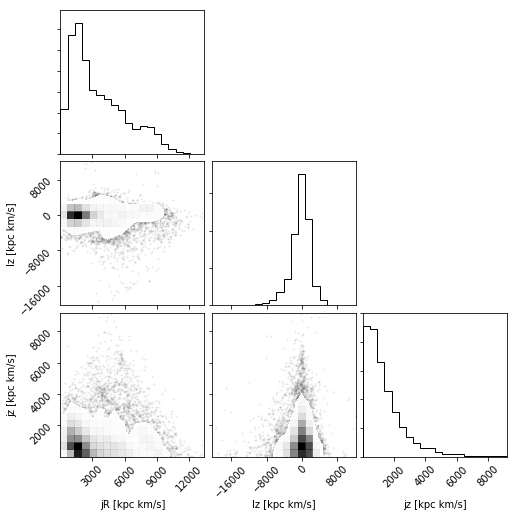

first ii
207.077834575
125
117
snapnr: 120
15:15:40.057706
[ 31.74212646  30.57429314  34.21273041]
Found 1726323 stars.
Rotated pos.
Rotated vel.
9728
[[    66.01809541    389.09616464    228.42265814 ...,   2457.14748525
    4067.59476534   5315.66649986]
 [    25.7016825    -103.76961658    443.74476921 ..., -20929.71215
  -19871.0245089  -17376.27470889]
 [   949.30998413    517.00629914    617.67762578 ...,    671.69436555
    1718.0714485    4174.94603029]]


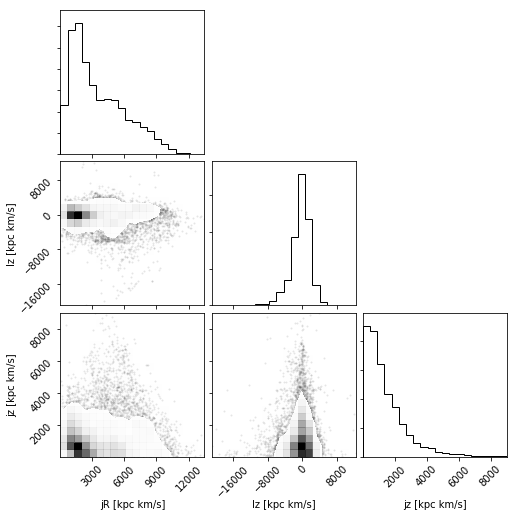

first ii
206.210635372
125
118
snapnr: 121
15:24:00.646980
[ 32.04627228  30.8679924   34.56239319]
Found 1736454 stars.
Rotated pos.
Rotated vel.
9728
[[   151.93422306    387.1083655     392.00475868 ...,   3144.06544033
    4842.66186521   6087.25864618]
 [    50.85977815    -38.75407483    120.38105282 ..., -20829.95973131
  -19655.34951666 -17419.47476933]
 [   795.17278278    616.69438645    734.0667494  ...,    612.27487716
    1534.92884546   3846.37297222]]


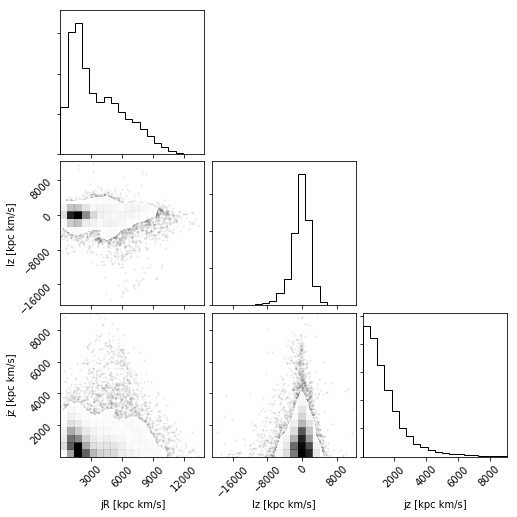

first ii
207.771531092
125
119
snapnr: 122
15:32:05.821020
[ 32.50867844  31.31370544  35.09283066]
Found 1755643 stars.
Rotated pos.
Rotated vel.
9728
[[    56.61401246    451.64879283    434.96307558 ...,   4205.01312813
    6043.91979371   7368.68937446]
 [   149.94495184    166.90426275   -112.9511231  ..., -20625.78513205
  -19382.19630344 -17433.12871399]
 [   638.37233129    287.97624866    352.09273955 ...,    543.26072342
    1298.57028808   3406.23514028]]


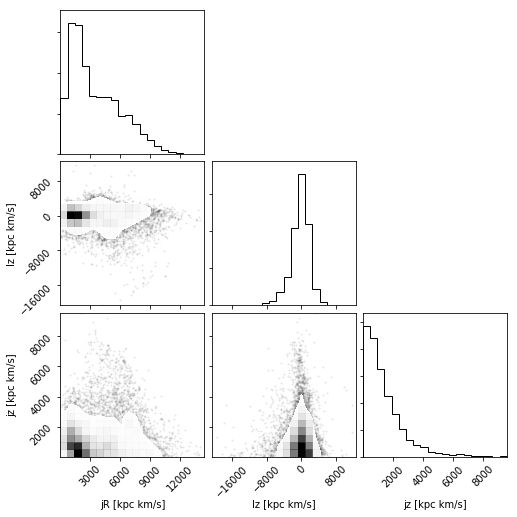

first ii
206.407548614
125
120
snapnr: 123
15:40:11.337517
[ 32.82047653  31.61475182  35.45058823]
Found 1755878 stars.
Rotated pos.
Rotated vel.
9728
[[    66.9140873     595.58497408    222.46819571 ...,   4422.13427334
    6193.24583025   7549.8651063 ]
 [   170.94044142    196.4014696     -61.6884022  ..., -21392.03096941
  -20198.79559527 -18337.48050288]
 [   642.80335851    204.61890795    966.27839127 ...,    471.78045355
    1136.83908983   3041.60527411]]


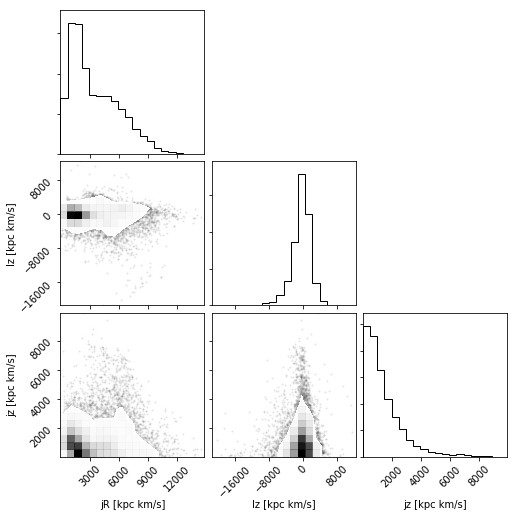

first ii
207.073589167
125
121
snapnr: 124
15:48:25.960179
[ 33.29346848  32.07149124  35.99433899]
Found 1758643 stars.
Rotated pos.
Rotated vel.
9728
[[    74.89954519    552.21108899    369.70384183 ...,   5150.3602309
    7025.54867354   8535.00946722]
 [    25.29136139    184.10474966   -140.05319709 ..., -20967.09035651
  -19581.17667699 -17539.98864709]
 [   783.11289009    167.84223339    574.4462004  ...,    442.44191524
    1125.34470294   3040.84398394]]


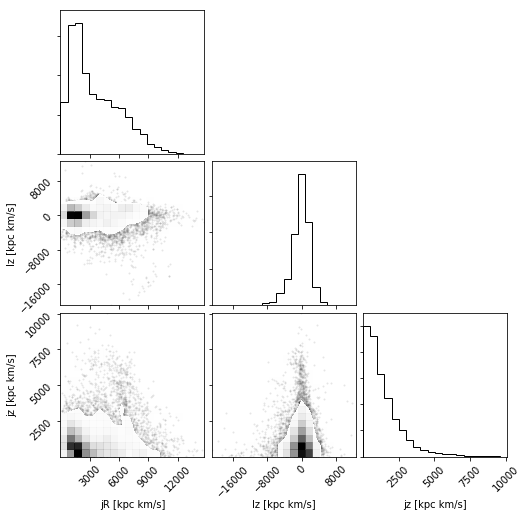

first ii
209.34587574
125
122
snapnr: 125
15:56:27.583636
[ 33.61259842  32.37949753  36.36141205]
Found 1769475 stars.
Rotated pos.
Rotated vel.
9728
[[  5.66333489e+01   4.05537663e+02   4.14746987e+02 ...,   5.62094397e+03
    7.54407087e+03   9.19560566e+03]
 [  9.84839517e-01   2.42571011e+02  -1.56581973e+02 ...,  -2.07210970e+04
   -1.92960830e+04  -1.71815318e+04]
 [  8.23094441e+02   3.82761134e+02   6.76894598e+02 ...,   4.22878895e+02
    1.08770738e+03   2.92859624e+03]]


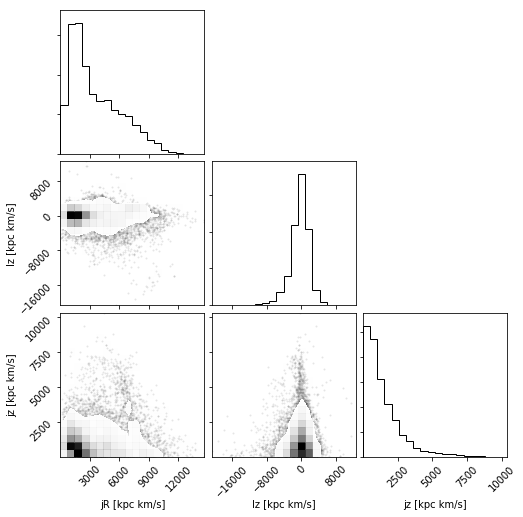

first ii
208.403892508
125
123
snapnr: 126
16:04:55.785170
[ 34.09642792  32.84707642  36.91917419]
Found 1774142 stars.
Rotated pos.
Rotated vel.
9728
[[   153.78090022    445.40667032    147.88996402 ...,   5980.82552197
    7913.75056444   9759.74655582]
 [   -98.76670185    176.28539922    -40.09478965 ..., -21165.2253351
  -19730.88083853 -17496.33611772]
 [   720.44014184    487.9562981     883.04238429 ...,    358.80016659
     984.35065095   2677.73030076]]


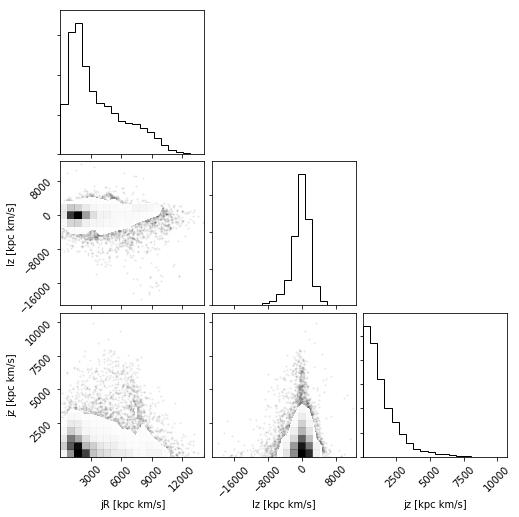

first ii
209.041785408
125
124
snapnr: 127
16:13:18.444979
[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated vel.
9728
[[   131.69989576    632.19877448     78.42949288 ...,   6302.19101514
    8233.15891273  10205.10226255]
 [  -173.8157513     212.99766679    -72.33386239 ..., -21056.93285265
  -19703.79430098 -17585.11229803]
 [   820.49659546     92.99882569   1163.30477782 ...,    301.6700823
     834.79411194   2308.56362757]]


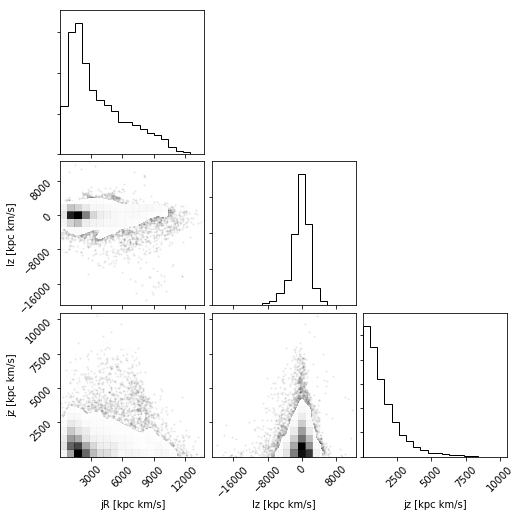

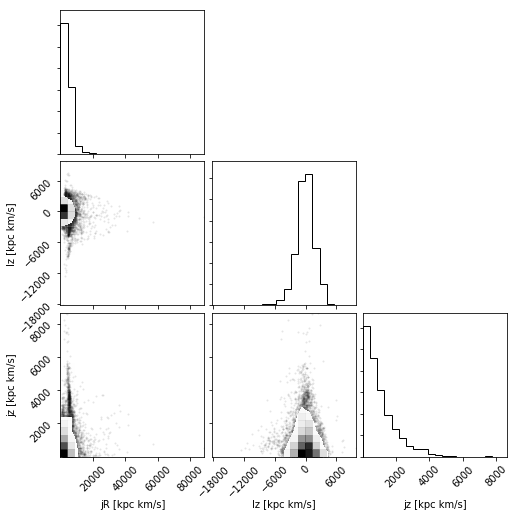

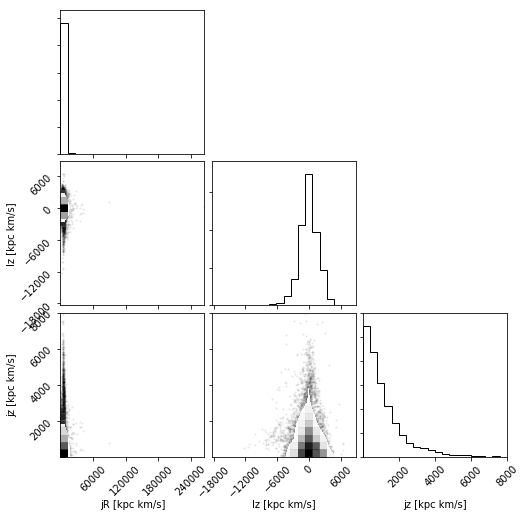

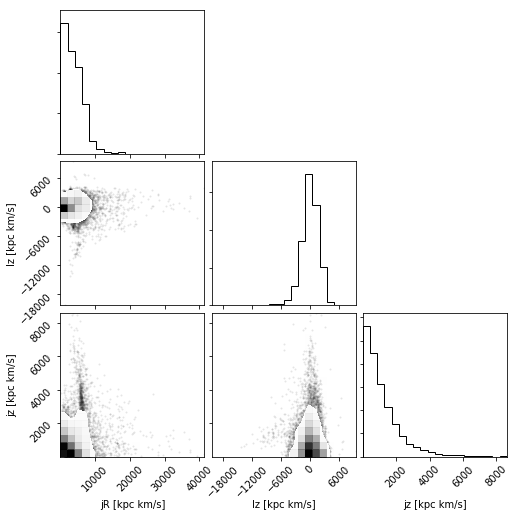

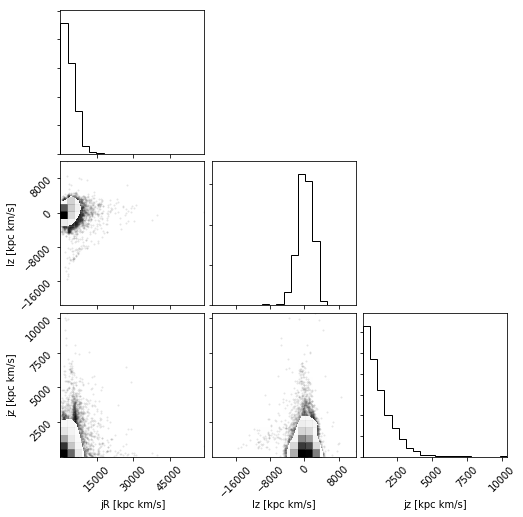

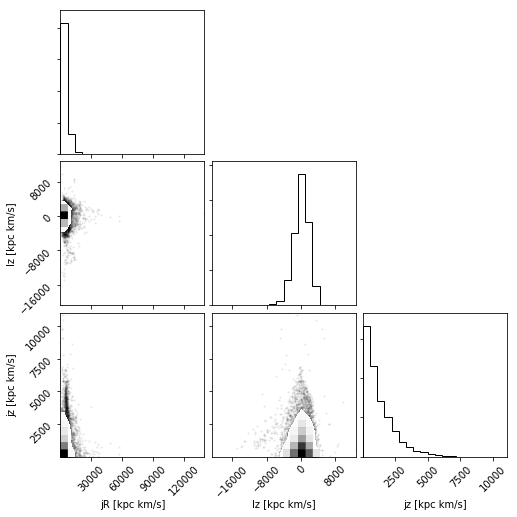

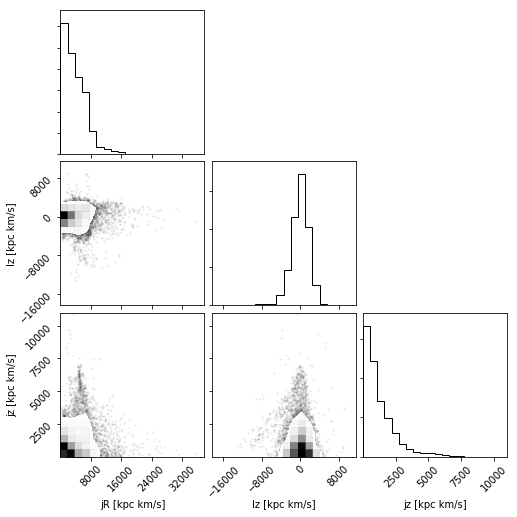

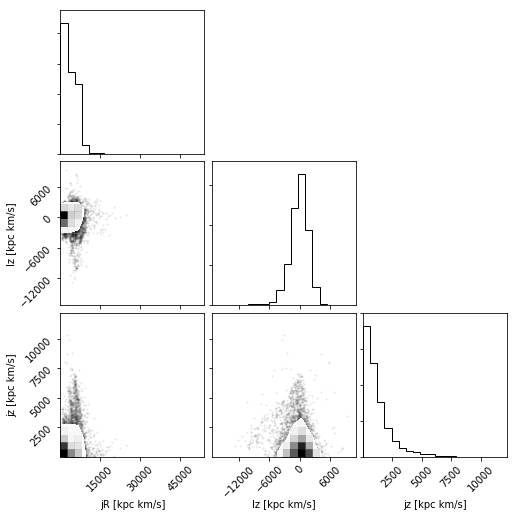

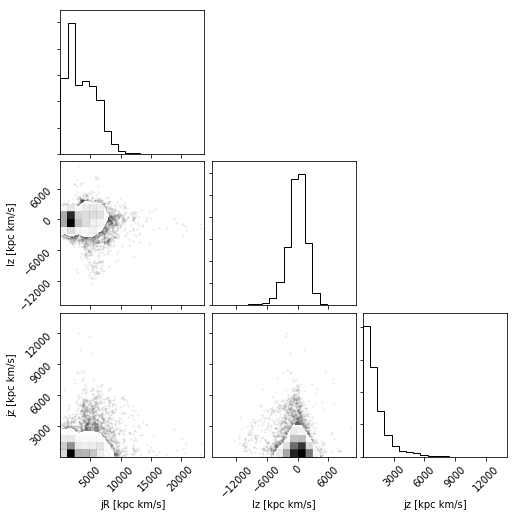

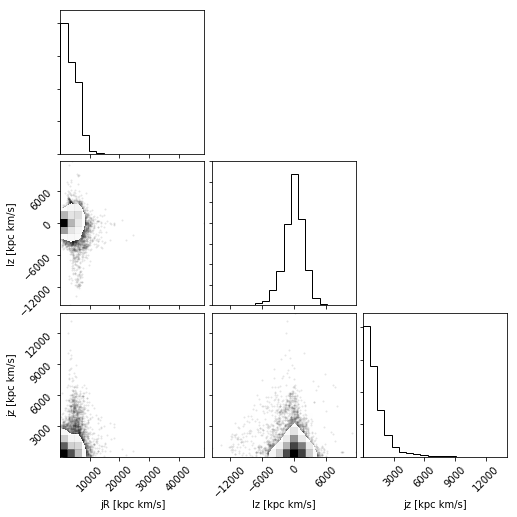

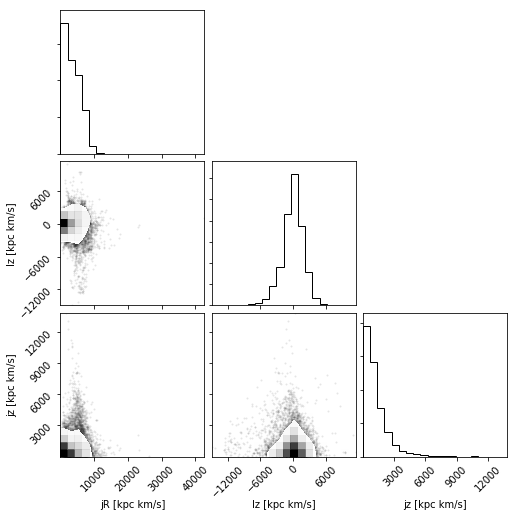

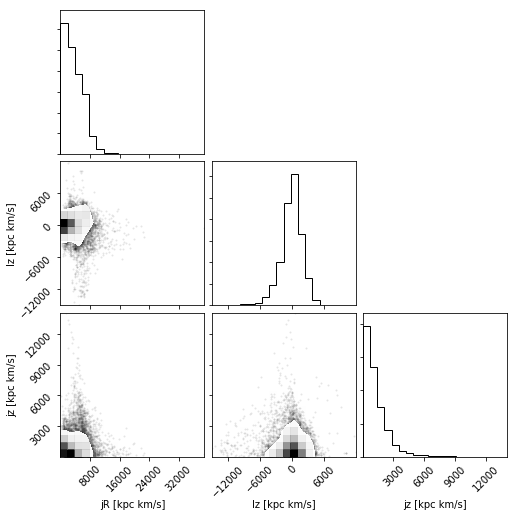

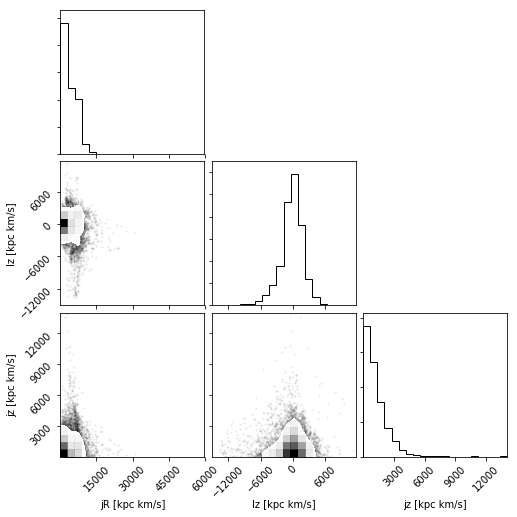

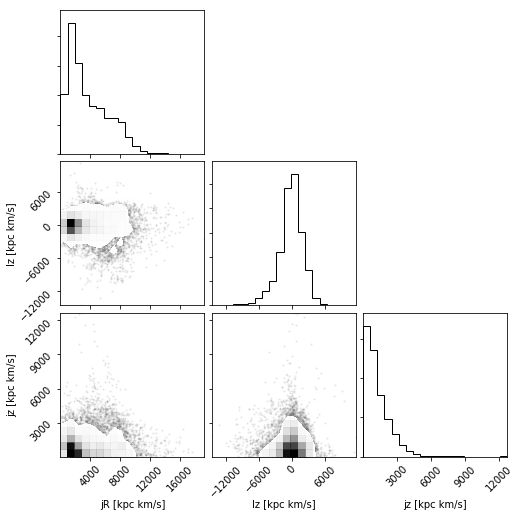

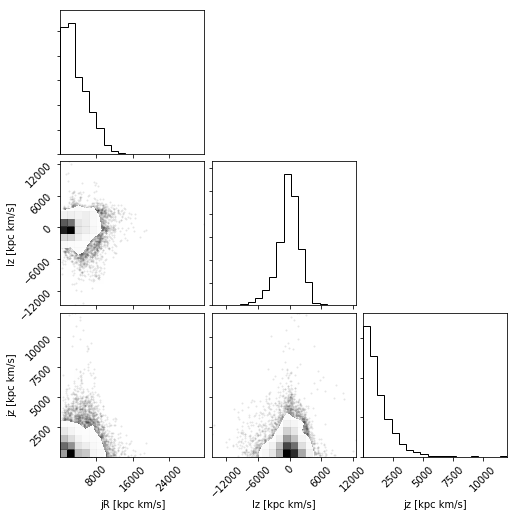

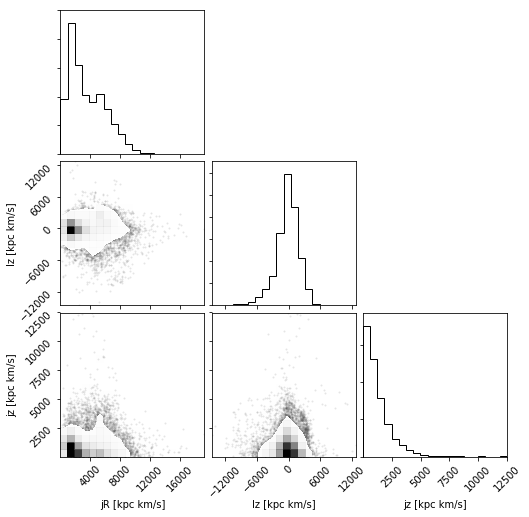

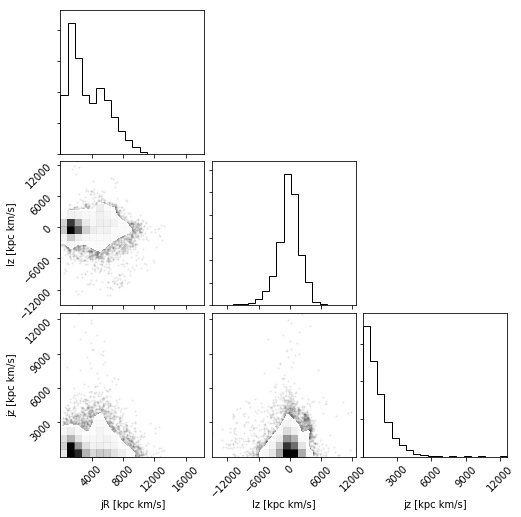

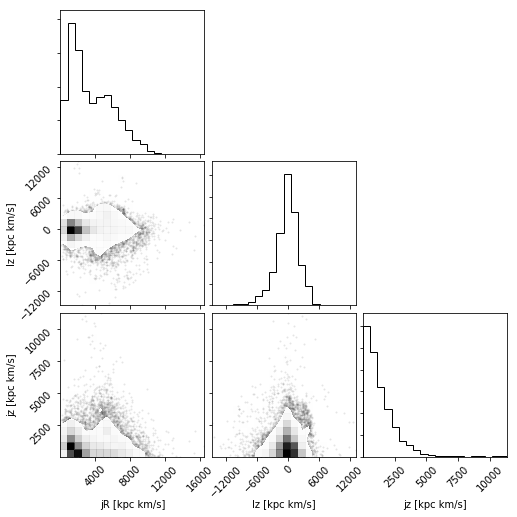

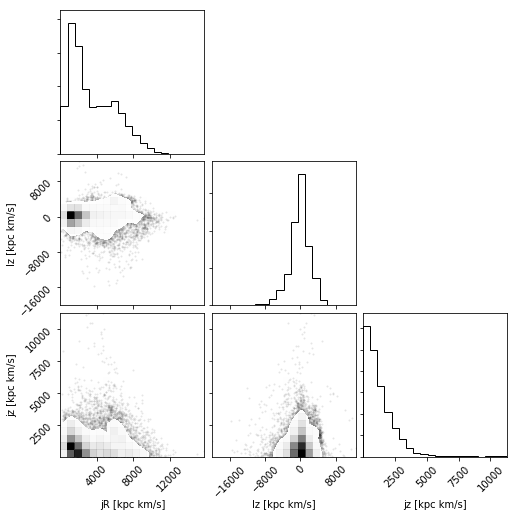

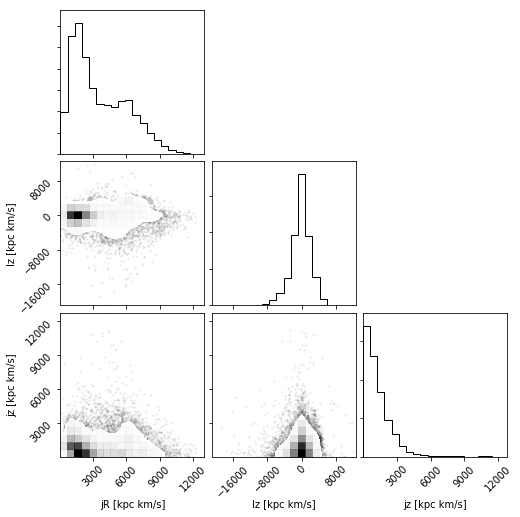

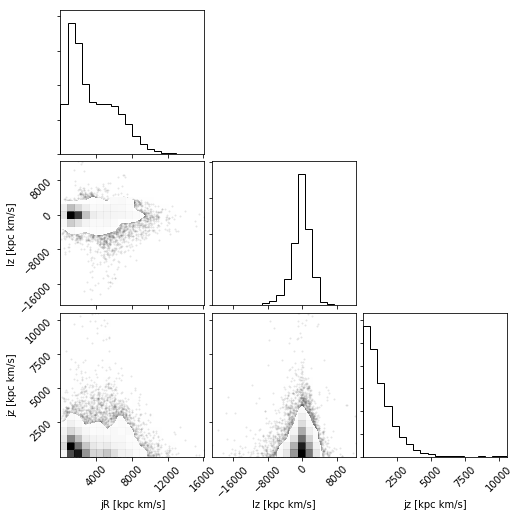

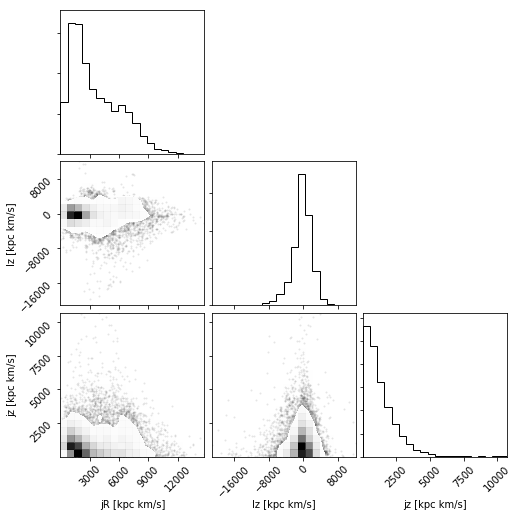

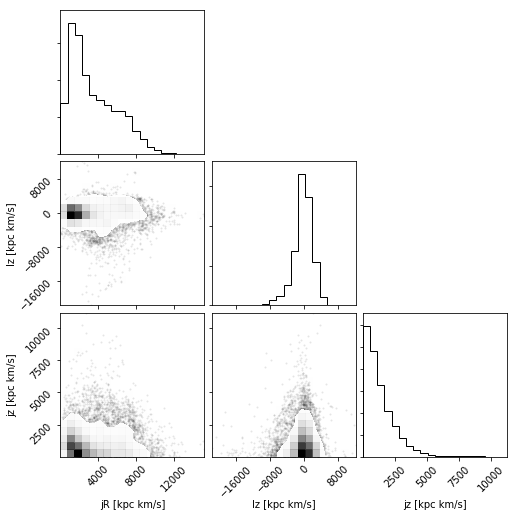

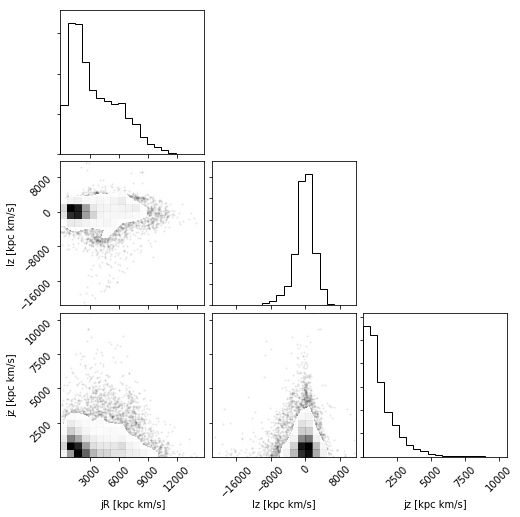

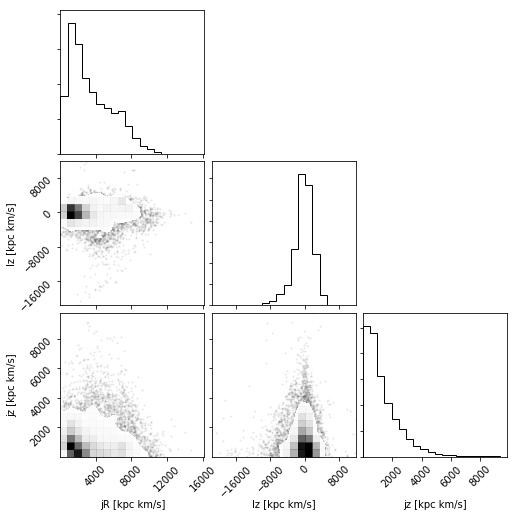

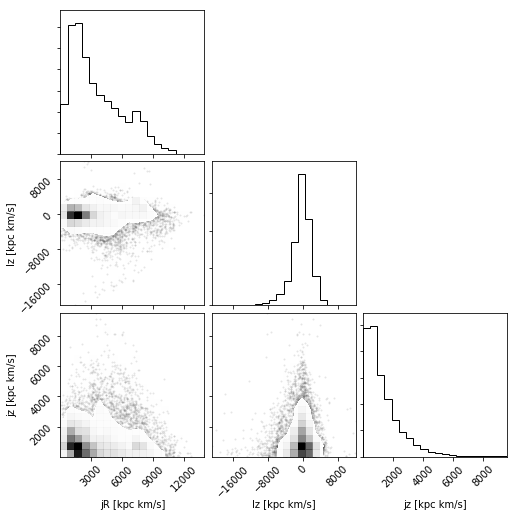

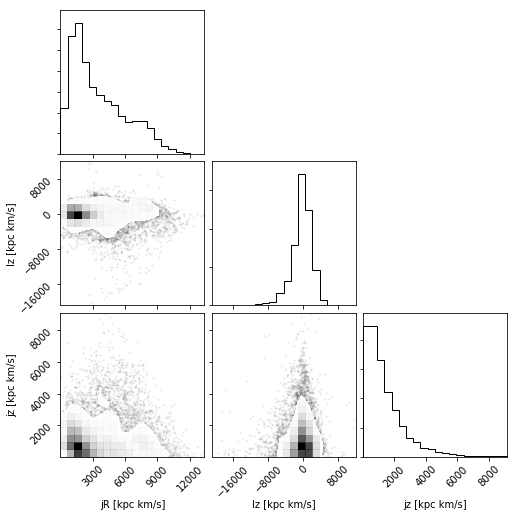

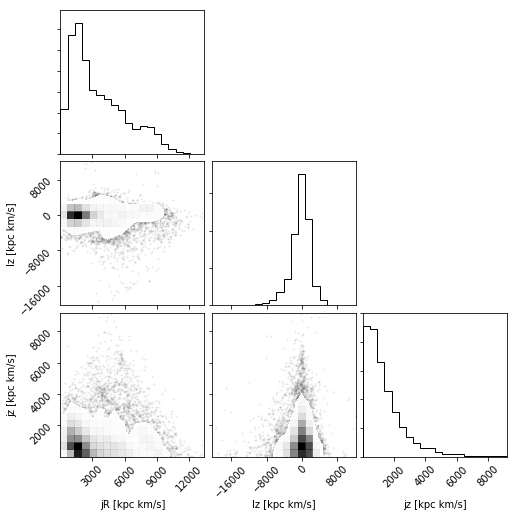

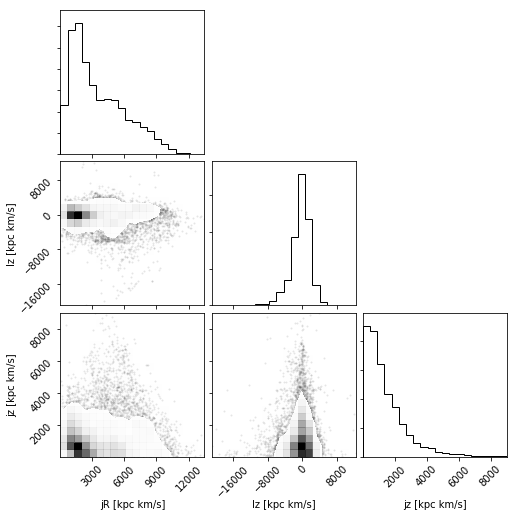

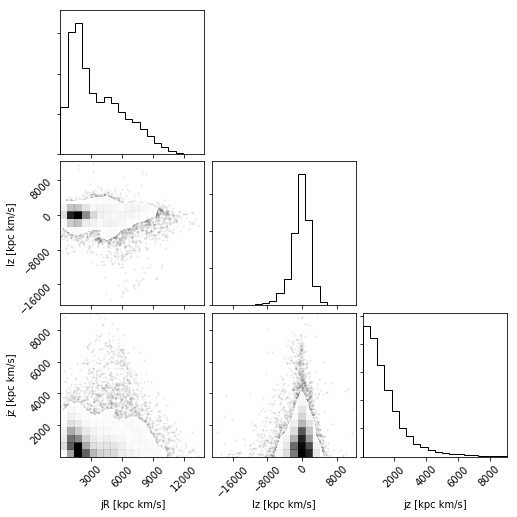

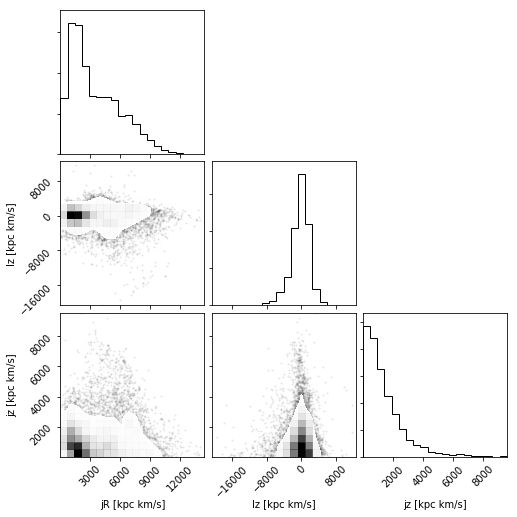

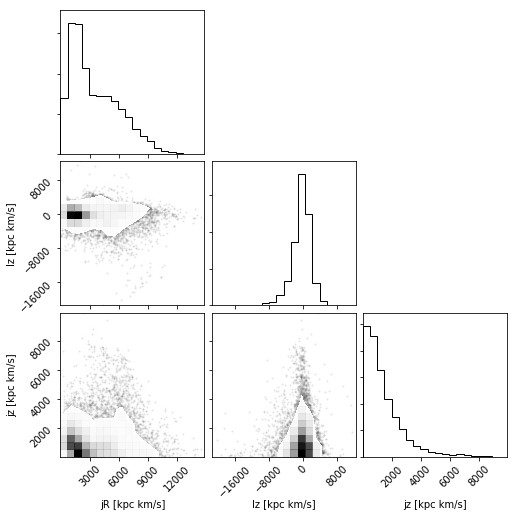

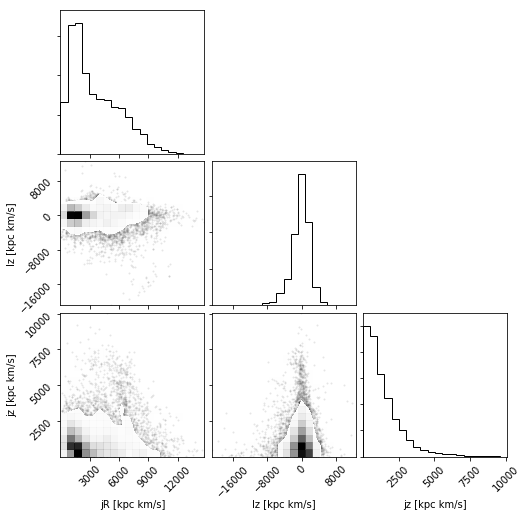

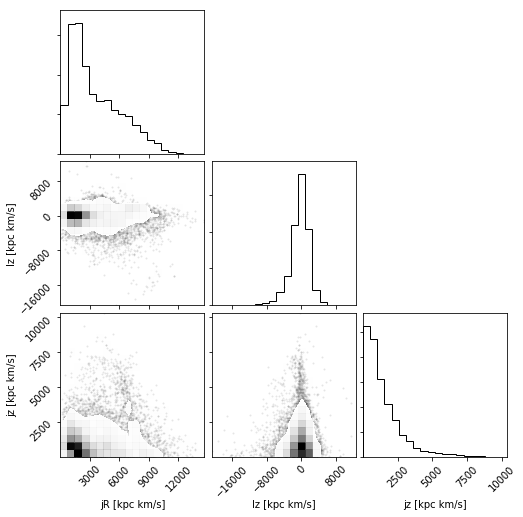

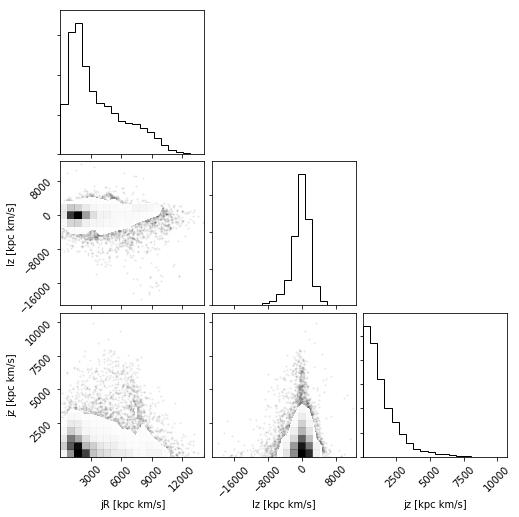

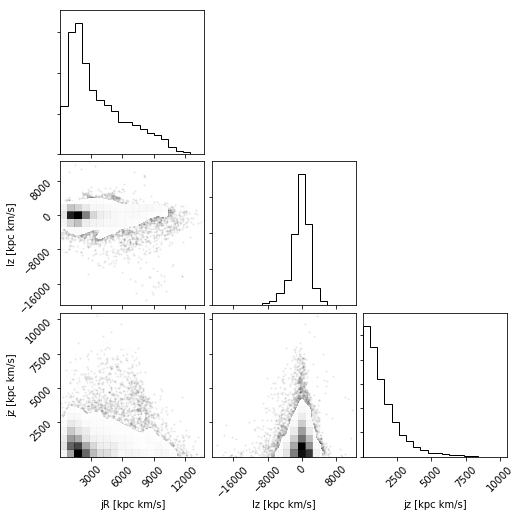

In [ ]:
# load fitted potential parameters
pot_params = np.loadtxt(filedir + 'potential_params_1000.txt')

snapnr          = pot_params[:,0]
v0_kms          = pot_params[:,1]
v0_kms_err      = pot_params[:,2]
a_MND_kpc       = pot_params[:,3]
a_MND_kpc_err   = pot_params[:,4]
b_MND_kpc       = pot_params[:,5]
b_MND_kpc_err   = pot_params[:,6]
a_NFWH_kpc      = pot_params[:,7]
a_NFWH_kpc_err  = pot_params[:,8]
a_HB_kpc        = pot_params[:,9]
a_HB_kpc_err    = pot_params[:,10]
n_MND           = pot_params[:,11]
n_MND_err       = pot_params[:,12]
n_NFWH          = pot_params[:,13]
n_NFWH_err      = pot_params[:,14]
n_HB            = pot_params[:,15]
n_HB_err        = pot_params[:,16]
true_fit = True

print(v0_kms)
# make snapnrs to integers
snapnr = np.array(snapnr, dtype = int)

# load smoothed fitted potential parameters
jj = 17
fitted_pot_params = np.loadtxt(filedir + 'fitted_potparams_w_' + str(jj)+'_pols.txt')
#v0_kms          = fitted_pot_params[0, :]
#a_MND_kpc       = fitted_pot_params[1, :]
#b_MND_kpc       = fitted_pot_params[2, :]
#a_NFWH_kpc      = fitted_pot_params[3, :]
#a_HB_kpc        = fitted_pot_params[4, :]
#n_MND           = fitted_pot_params[5, :]
#n_NFWH          = fitted_pot_params[6, :]
#n_HB            = fitted_pot_params[7, :]
#true_fit = False
#smooth_fit = True

print(v0_kms)

# startnr is number of first snapshot to calculate its actions (of the GCs with merger IDs)
startnr = 93 # worked for the first time in 93
# endnumber is last snapshot plus 1 (since I use range function)
endnr = int(np.max(snapnr) + 1) 
# NRSNAPSHOTS USELESS ATM
nrsnapshots = int(endnr-startnr)
# helping parameter to distinguish between first corner plot as base figure to plot other corner plots on
init = 0

# figure related color 
color = 'pink'


halo_number = 24  # range(1, 31):
halodir = basedir + "halo_{0}/".format(halo_number)
snappath = halodir + "output/"
for snap_number in range(startnr, endnr, 1):
    # make index starting from 0 for potential parameters
    if true_fit == True:    
        print('first ii')
        ii = snapnr.tolist().index(snap_number)
    elif smooth_fit == True:
        print('second ii')
        ii = int(snap_number - 7)
    else:
        ii = snap_number
        print('Check snap index!')
    print(v0_kms[ii])
    print(len(v0_kms))
    print(ii)
    print("snapnr: {0}".format(snap_number))
    print(datetime.datetime.now().time())
    s1, sf1 = eat_snap_and_fof(level, halo_number, snap_number, snappath, loadonlytype=[4], 
        haloid=0, galradfac=0.1, verbose=False) 

    # Clean negative and zero values of gmet to avoid RuntimeErrors
    # later on (e.g. dividing by zero)
    s1.data['gmet'] = np.maximum( s1.data['gmet'], 1e-40 ) 

    # create masks for merged stars according to their IDs to get their positions
    gcmask = np.isin(s1.id, IDS)
    print(np.sum(gcmask))
    # PROBABLY DO NOT NEED THESE VALUES
    (x1_merg_kpc, y1_merg_kpc, z1_merg_kpc), (vx1_merg_kms, vy1_merg_kms, vz1_merg_kms), rxyz1_merg_kpc, rxy1_merg_kpc = get_cartesian_vectors(s1, sf1, gcmask)
    
    # set up galpy potential with values of potential fitting (either smoothed or not, depends on commenting out or not)
    pot_galpy = setup_galpy_potential(a_MND_kpc[ii], b_MND_kpc[ii], a_NFWH_kpc[ii], a_HB_kpc[ii], n_MND[ii], n_NFWH[ii], n_HB[ii])
    
    # this would mean that there are no merged GCs
    if np.sum(gcmask) == 0:
        continue
        
    # get position and velocities of all selected GCs & convert to galpy units
    (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s1, sf1, gcmask)
    # convert physical to galpy units by dividing by REF vals (get velocities from best fit parameters)
    R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy = R_kpc / _REFR0_kpc, vR_kms / v0_kms[ii], vphi_kms / v0_kms[ii], z_kpc / _REFR0_kpc, vz_kms / v0_kms[ii]

    # estimate Delta of the Staeckel potential
    delta = 0.45
    delta = estimateDeltaStaeckel(pot_galpy, R_galpy, z_galpy)
    # CHECK HOW BIG INFLUENCE OF DELTA IS
    
    
    # set up the actionAngleStaeckel object
    aAS = actionAngleStaeckel(
            pot   = pot_galpy,  # potential
            delta = delta,      # focal length of confocal coordinate system
            c     = True        # use C code (for speed)
            )
    #### calculate actions (in galpy units) & convert them to physical units
    # CONTINUE COMMENTING FROM HERE
    r_condition = np.where((np.sqrt(R_kpc**2 + z_kpc**2)) <= (2000. * s1.galrad))
    jR_kpckms, lz_kpckms, jz_kpckms = np.zeros(len(IDS)), np.zeros(len(IDS)), np.zeros(len(IDS))
    savedids = np.zeros(len(IDS))
    '''
    for test_i, item in enumerate(IDS):
        if (test_i % 1000) == 0:
            print(datetime.datetime.now().time())
            print(test_i)
        if np.sum(np.isin(r_condition, test_i)):
            #try: 
    '''
    try:
        jR_galpy, lz_galpy, jz_galpy = aAS(R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy)
    except:
        print('did not work!')
        continue
    jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * _REFR0_kpc * v0_kms[ii], lz_galpy * _REFR0_kpc * v0_kms[ii], jz_galpy * _REFR0_kpc * v0_kms[ii]
    #savedids[test_i] = item
            #except ValueError:
                #continue
    #survivor_id_mask = np.isin(IDS, savedids)
    #survivor_ids = IDS[survivor_id_mask]
    #print(len(survivor_ids))
    #print(2000. * s1.galrad)
    # prepare data for plotting and create corner plot
    data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
    
    print(data)
    labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']

    figure = corner.corner(data.transpose(), labels = labels, plot_contours = 0, norm=matplotlib.colors.LogNorm(), cmap = cmap)
    display(figure)

starting first figure


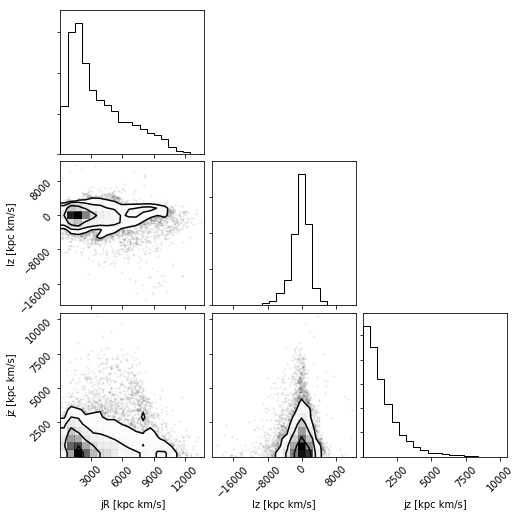

In [ ]:
labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
init = 0
repeater = 1
if init == 0:
    print('starting first figure')
    figure = corner.corner(data.transpose(), labels = labels)#, plot_contours = 1, color = color, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])
    init +=1
else:
    print('start other figures')
    figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, fig = figure, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])            
#figure.suptitle(num + ' ' + title + '\nnumber of GCs: ' + str(len(R_kpc[r_condition])) + '\n$\Delta$ Staeckel: ' + "{:2.2f}".format(delta));

#display(figure)
if repeater == 0:
    print('number of all selected GCs', np.sum(gcmask), 'num of GCs within 50kpc:', len(r_condition[0]))

In [ ]:
figure

In [ ]:
cmap = copy.copy(plt.cm.inferno)
cmap.set_bad((0,0,0))  # Fill background with black
norm=matplotlib.colors.LogNorm()
s_snap = np.arange(startnr,endnr,1)

### for xy plot ###
X = x_mergers[0]
Y = y_mergers[0]
X = np.append(X, [-151, 151])
Y = np.append(Y, [-151, 151])

fig, ax = plt.subplots(figsize = (8,8))
ax.set_ylim([-150, 150])
ax.set_xlim([-150, 150])
#Create 2d Histogram
data,x,y = np.histogram2d(X,Y, bins = 401)
#data_bg,x_bg,y_bg = np.histogram2d(X_bg,Y_bg, bins = 501)


#Smooth with filter
ext = (np.min(X), np.max(X), np.min(Y), np.max(Y))
im = plt.imshow(data.T, interpolation = 'gaussian', cmap = cmap, norm=norm, extent = ext, animated=True)
ax.set_xlabel('x [kpc]')
ax.set_ylabel('y [kpc]')
time_text = ax.text(0.1, 0.9,'', color = 'orange', transform=ax.transAxes, fontsize=16)

#Define animation. 
def animate(i) :
    
    X = x_mergers[i]
    Y = y_mergers[i]
    X = np.append(X, [-201, 201])
    Y = np.append(Y, [-201, 201])
    data,x,y = np.histogram2d(X,Y, bins = 501)
    im.set_data(data.T)
    time_text.set_text('Snapshot ' + str(snapnrs[i]) )
    

anim_xy = animation.FuncAnimation(fig, animate, frames=len(s_snap))

plt.show()

anim_xy.save('../plots/merger73_spatial_xy_dist.gif',writer='imagemagick',fps=3)

### for Rz plot ###
X = R_mergers[0]
Y = z_mergers[0]
X = np.append(X, [-151, 151])
Y = np.append(Y, [-151, 151])

fig, ax = plt.subplots(figsize = (8,8))
ax.set_ylim([-150, 150])
ax.set_xlim([-150, 150])
#Create 2d Histogram
data,x,y = np.histogram2d(X,Y, bins = 401)
#data_bg,x_bg,y_bg = np.histogram2d(X_bg,Y_bg, bins = 501)


#Smooth with filter
ext = (np.min(X), np.max(X), np.min(Y), np.max(Y))
im = plt.imshow(data.T, interpolation = 'gaussian', cmap = cmap, norm=norm, extent = ext, animated=True)
ax.set_xlabel('R [kpc]')
ax.set_ylabel('z [kpc]')
time_text = ax.text(0.1, 0.9,'', color = 'orange', transform=ax.transAxes, fontsize=16)

#Define animation. 
def animate(i) :
    
    X = R_mergers[i]
    Y = z_mergers[i]
    X = np.append(X, [-201, 201])
    Y = np.append(Y, [-201, 201])
    data,x,y = np.histogram2d(X,Y, bins = 501)
    im.set_data(data.T)
    time_text.set_text('Snapshot ' + str(snapnrs[i]) )
    

anim_Rz = animation.FuncAnimation(fig, animate, frames=len(s_snap))

plt.show()

anim_Rz.save('../plots/merger73_spatial_Rz_dist.gif',writer='imagemagick',fps=3)



In [ ]:
cmap = copy.copy(plt.cm.inferno)
cmap.set_bad((0,0,0))  # Fill background with black

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
h = ax.hist2d(rxy2_merg_kpc, z2_merg_kpc, bins=401, norm=matplotlib.colors.LogNorm(), cmap = cmap)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("z [kpc]")
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(h[3], cax=cax)


In [ ]:
pot_galpy = setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB)
for ID in id_list:    
    gcmask = np.isin(s.id, ID)

    if np.sum(gcmask) == 0:
        continue
    # get position and velocities of all selected GCs & convert to galpy units
    (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, gcmask)
    R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy = R_kpc / _REFR0_kpc, vR_kms / _REFV0_kms, vphi_kms / _REFV0_kms, z_kpc / _REFR0_kpc, vz_kms / _REFV0_kms

    # estimate Delta of the Staeckel potential
    delta = estimateDeltaStaeckel(pot_galpy, R_galpy, z_galpy)

    # set up the actionAngleStaeckel object
    aAS = actionAngleStaeckel(
            pot   = pot_galpy,  # potential
            delta = delta,      # focal length of confocal coordinate system
            c     = True        # use C code (for speed)
            )
    # calculate actions (in galpy units) & convert them to physical units
    r_condition = np.where((np.sqrt(R_kpc**2 + z_kpc**2)) <= 50.)

    jR_galpy, lz_galpy, jz_galpy = aAS(R_galpy[r_condition], vR_galpy[r_condition], vT_galpy[r_condition], z_galpy[r_condition], vz_galpy[r_condition])
    jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * _REFR0_kpc * _REFV0_kms, lz_galpy * _REFR0_kpc * _REFV0_kms, jz_galpy * _REFR0_kpc * _REFV0_kms

    # prepare data for plotting and create corner plot
    data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
    labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
    if init == 0:
        figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])
        init +=1
    else:
        figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, fig = figure, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])            
    #figure.suptitle(num + ' ' + title + '\nnumber of GCs: ' + str(len(R_kpc[r_condition])) + '\n$\Delta$ Staeckel: ' + "{:2.2f}".format(delta));

    #display(figure)
    if repeater == 0:
        print('number of all selected GCs', np.sum(gcmask), 'num of GCs within 50kpc:', len(r_condition[0]))


In [ ]:
s_snap = np.arange(startnr,endnr,1)

fig, ax = plt.subplots(figsize = (8,8))

data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']


figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, fig = figure, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])            

#Smooth with filter
ext = (np.min(X), np.max(X), np.min(Y), np.max(Y))
im = plt.imshow(data.T, interpolation = 'gaussian', cmap = cmap, norm=norm, extent = ext, animated=True)
ax.set_xlabel('x [kpc]')
ax.set_ylabel('y [kpc]')
time_text = ax.text(0.1, 0.9,'', color = 'orange', transform=ax.transAxes, fontsize=16)

#Define animation. 
def animate(i) :
    
    X = x_mergers[i]
    Y = y_mergers[i]
    X = np.append(X, [-201, 201])
    Y = np.append(Y, [-201, 201])
    data,x,y = np.histogram2d(X,Y, bins = 501)
    im.set_data(data.T)
    time_text.set_text('Snapshot ' + str(snapnrs[i]) )
    

anim_xy = animation.FuncAnimation(fig, animate, frames=len(s_snap))

plt.show()

anim_xy.save('../plots/merger73_spatial_xy_dist.gif',writer='imagemagick',fps=3)

### for Rz plot ###
X = R_mergers[0]
Y = z_mergers[0]
X = np.append(X, [-151, 151])
Y = np.append(Y, [-151, 151])

fig, ax = plt.subplots(figsize = (8,8))
ax.set_ylim([-150, 150])
ax.set_xlim([-150, 150])
#Create 2d Histogram
data,x,y = np.histogram2d(X,Y, bins = 401)
#data_bg,x_bg,y_bg = np.histogram2d(X_bg,Y_bg, bins = 501)


#Smooth with filter
ext = (np.min(X), np.max(X), np.min(Y), np.max(Y))
im = plt.imshow(data.T, interpolation = 'gaussian', cmap = cmap, norm=norm, extent = ext, animated=True)
ax.set_xlabel('R [kpc]')
ax.set_ylabel('z [kpc]')
time_text = ax.text(0.1, 0.9,'', color = 'orange', transform=ax.transAxes, fontsize=16)

#Define animation. 
def animate(i) :
    
    X = R_mergers[i]
    Y = z_mergers[i]
    X = np.append(X, [-201, 201])
    Y = np.append(Y, [-201, 201])
    data,x,y = np.histogram2d(X,Y, bins = 501)
    im.set_data(data.T)
    time_text.set_text('Snapshot ' + str(snapnrs[i]) )
    

anim_Rz = animation.FuncAnimation(fig, animate, frames=len(s_snap))

plt.show()

anim_Rz.save('../plots/merger73_spatial_Rz_dist.gif',writer='imagemagick',fps=3)



In [ ]:
# schau die animationsdokumentation genauer an um zu sehen was ich wann einlesen muss und worueber gelooped werden muss
# entweder save as files oder finde einen anderen weg, wie ich die ids kriege 
def plot_action_corner():
    

In [ ]:
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*

### ____ fit actions to stars so only load type 4 ____

level = 4

startnr = 72 # nr of snapshot where dwarf is first merged

j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(startnr,128,1):
        print("snapnr  : {0}".format(snapnr))
        print(datetime.datetime.now().time())
        try:
            s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[4], 
            haloid=0, galradfac=0.1, verbose=False) 
        except KeyError:
            print('\n\n', snapnr, 'not read in.\n\n')
            continue

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
        '''
        if j == 0:
            # initialize figure if not given as input
            j +=1
        else:
        '''

In [ ]:
### write a function out of the routine above
# read in ID lists generated in notebook 2dwarf

#def 

org_dwarfs = ['72']
pot_fit_routines = ['diff_ev', 'emcee1', 'emcee2']
repeater = 0
for routine in pot_fit_routines:
    init = 0

    for num in org_dwarfs:
        if num == '57':
            color = 'red'
        elif num == '67':
            color = 'blue'
        elif num == '72':
            color = 'green' 
            print('Heloohohohohohoheihfhufbe')
        ids_notused = np.loadtxt(filedir + 'surviving_ids_snapshot_' + num + '_sh_1.txt', dtype = 'int') # 2648 particles 
        ids = np.loadtxt(filedir + 'surviving_ids_zsignchange_snapshot_' + num + '_sh_1.txt', dtype = 'int') # 93 particles

        id_list = [ids_notused] #ids

        # read in the different results of the different fitting routines of notebook 1pot
        
        if routine == 'diff_ev':
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_diff_ev.txt')
            title = 'differential evolution'
        elif routine == 'emcee1':
            repeater = 1
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_emcee1.txt')
            title = '1st MCMC'
        elif routine == 'emcee2':
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_emcee2.txt')
            title = '2nd MCMC'
        else:
            raise FileNotFoundError  

        _REFV0_kms = v0_kms

        pot_galpy = setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB)
        for ID in id_list:    
            gcmask = np.isin(s.id, ID)

            if np.sum(gcmask) == 0:
                continue
            # get position and velocities of all selected GCs & convert to galpy units
            (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, gcmask)
            R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy = R_kpc / _REFR0_kpc, vR_kms / _REFV0_kms, vphi_kms / _REFV0_kms, z_kpc / _REFR0_kpc, vz_kms / _REFV0_kms

            # estimate Delta of the Staeckel potential
            delta = estimateDeltaStaeckel(pot_galpy, R_galpy, z_galpy)

            # set up the actionAngleStaeckel object
            aAS = actionAngleStaeckel(
                    pot   = pot_galpy,  # potential
                    delta = delta,      # focal length of confocal coordinate system
                    c     = True        # use C code (for speed)
                    )
            # calculate actions (in galpy units) & convert them to physical units
            r_condition = np.where((np.sqrt(R_kpc**2 + z_kpc**2)) <= 50.)
            
            jR_galpy, lz_galpy, jz_galpy = aAS(R_galpy[r_condition], vR_galpy[r_condition], vT_galpy[r_condition], z_galpy[r_condition], vz_galpy[r_condition])
            jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * _REFR0_kpc * _REFV0_kms, lz_galpy * _REFR0_kpc * _REFV0_kms, jz_galpy * _REFR0_kpc * _REFV0_kms

            # prepare data for plotting and create corner plot
            data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
            labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
            if init == 0:
                figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])
                init +=1
            else:
                figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, fig = figure, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])            
            #figure.suptitle(num + ' ' + title + '\nnumber of GCs: ' + str(len(R_kpc[r_condition])) + '\n$\Delta$ Staeckel: ' + "{:2.2f}".format(delta));
            
            #display(figure)
            if repeater == 0:
                print('number of all selected GCs', np.sum(gcmask), 'num of GCs within 50kpc:', len(r_condition[0]))
    '''            
    #MW potential
    from galpy.potential import MWPotential
    MWV0_kms = 220

    # estimate Delta of the Staeckel potential
    delta = estimateDeltaStaeckel(MWPotential, R_galpy, z_galpy)

    # set up the actionAngleStaeckel object
    aAS = actionAngleStaeckel(
            pot   = MWPotential,  # potential
            delta = delta,      # focal length of confocal coordinate system
            c     = True        # use C code (for speed)
            )
    # calculate actions (in galpy units) & convert them to physical units
    r_condition = np.where((R_kpc + z_kpc) <= 50.)

    jR_galpy, lz_galpy, jz_galpy = aAS(R_galpy[r_condition], vR_galpy[r_condition], vT_galpy[r_condition], z_galpy[r_condition], vz_galpy[r_condition])
    jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * _REFR0_kpc * MWV0_kms, lz_galpy * _REFR0_kpc * MWV0_kms, jz_galpy * _REFR0_kpc * MWV0_kms

    data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
    labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
    figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = 'black', fig = figure)            
    
    
    '''

In [ ]:
data = np.vstack([R_kpc[r_condition], phi_rad[r_condition], z_kpc[r_condition]])
labels = ['R[kpc]', 'phi[rad]', 'z[kpc]']
corner.corner(data.transpose(), labels = labels, plot_contours = 0, color = color)

In [ ]:
# read in ID lists generated in notebook 2dwarf
org_dwarfs = ['72']
pot_fit_routines = ['emcee1']
repeater = 0
for routine in pot_fit_routines:
    init = 0

    for num in org_dwarfs:
        if num == '57':
            color = 'red'
        elif num == '67':
            color = 'blue'
        elif num == '72':
            color = 'green'            
        ids_notused = np.loadtxt(filedir + 'surviving_ids_snapshot_' + num + '_sh_1.txt', dtype = 'int') # 2648 particles 
        ids = np.loadtxt(filedir + 'surviving_ids_zsignchange_snapshot_' + num + '_sh_1.txt', dtype = 'int') # 93 particles

        id_list = [ids_notused] #ids
        print("ID list done")
        # read in the different results of the different fitting routines of notebook 1pot
        
        if routine == 'diff_ev':
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_diff_ev.txt')
            title = 'differential evolution'
        elif routine == 'emcee1':
            repeater = 1
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_emcee1.txt')
            title = '1st MCMC'
            print('Potential parameters there')
        elif routine == 'emcee2':
            v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_emcee2.txt')
            title = '2nd MCMC'
        else:
            raise FileNotFoundError  

        _REFV0_kms = v0_kms

        pot_galpy = setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB)
        print('Potential is set up.')
        for ID in id_list:    
            gcmask = np.isin(s.id, ID)

            if np.sum(gcmask) == 0:
                continue
            # get position and velocities of all selected GCs & convert to galpy units
            (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, gcmask)
            R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy = R_kpc / _REFR0_kpc, vR_kms / _REFV0_kms, vphi_kms / _REFV0_kms, z_kpc / _REFR0_kpc, vz_kms / _REFV0_kms
            print('Galpy vals gotten.')
            # estimate Delta of the Staeckel potential
            delta = estimateDeltaStaeckel(pot_galpy, R_galpy, z_galpy)

            # set up the actionAngleStaeckel object
            aAS = actionAngleStaeckel(
                    pot   = pot_galpy,  # potential
                    delta = delta,      # focal length of confocal coordinate system
                    c     = True        # use C code (for speed)
                    )
            print('Action object setup.')
            # calculate actions (in galpy units) & convert them to physical units
            r_condition = np.where((np.sqrt(R_kpc**2 + z_kpc**2)) <= 50.)
            
            jR_galpy, lz_galpy, jz_galpy = aAS(R_galpy[r_condition], vR_galpy[r_condition], vT_galpy[r_condition], z_galpy[r_condition], vz_galpy[r_condition])
            jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * _REFR0_kpc * _REFV0_kms, lz_galpy * _REFR0_kpc * _REFV0_kms, jz_galpy * _REFR0_kpc * _REFV0_kms
            print('actions calculated')
            # prepare data for plotting and create corner plot
            data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
            labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
            if init == 0:
                print('Figure started')
                figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])
                init +=1
            else:
                figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = color, fig = figure, range =  [(0.,12500.), (-14000.,14000.),(0., 5000.)])            
            #figure.suptitle(num + ' ' + title + '\nnumber of GCs: ' + str(len(R_kpc[r_condition])) + '\n$\Delta$ Staeckel: ' + "{:2.2f}".format(delta));
            
            #display(figure)
            if repeater == 0:
                print('number of all selected GCs', np.sum(gcmask), 'num of GCs within 50kpc:', len(r_condition[0]))
    '''            
    #MW potential
    from galpy.potential import MWPotential
    MWV0_kms = 220

    # estimate Delta of the Staeckel potential
    delta = estimateDeltaStaeckel(MWPotential, R_galpy, z_galpy)

    # set up the actionAngleStaeckel object
    aAS = actionAngleStaeckel(
            pot   = MWPotential,  # potential
            delta = delta,      # focal length of confocal coordinate system
            c     = True        # use C code (for speed)
            )
    # calculate actions (in galpy units) & convert them to physical units
    r_condition = np.where((R_kpc + z_kpc) <= 50.)

    jR_galpy, lz_galpy, jz_galpy = aAS(R_galpy[r_condition], vR_galpy[r_condition], vT_galpy[r_condition], z_galpy[r_condition], vz_galpy[r_condition])
    jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * _REFR0_kpc * MWV0_kms, lz_galpy * _REFR0_kpc * MWV0_kms, jz_galpy * _REFR0_kpc * MWV0_kms

    data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
    labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
    figure = corner.corner(data.transpose(), labels = labels, plot_contours = 1, color = 'black', fig = figure)            
    
    
    '''